In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

## Two body gravitational orbit
Two bodies are forming a system with the only gravitational force. The distance between m1 and m2 is
\\[
r=\sqrt{(x_1+x_2)^2+(y_1+y_2)^2}
\\]
The gravitational force between m1 and m2 is
\\[
F=\frac{Gm_1m_2}{r^2}
\\]
And the newton's second law $F=m\ddot x$ gives
\\[
\ddot x_1=\frac{Gm_2}{r^2}\frac{x_2-x_1}{r}\\
\ddot x_2=-\frac{Gm_1}{r^2}\frac{x_2-x_1}{r}\\
\ddot y_1=\frac{Gm_1}{r^2}\frac{y_2-y_1}{r}\\
\ddot y_2=-\frac{Gm_2}{r^2}\frac{y_2-y_1}{r}
\\]

In [3]:
class Two_Body:    
    def __init__(self, G=1., m1=1., m2=1.):
        self.G = G
        self.m1 = m1
        self.m2 = m2
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dx1/dt d^2x1/dt^2 
         dx2/dt d^2x2/dt^2
         dy1/dt d^2y1/dt^2
         dy2/dt d^2y2/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            8-component vector with y[0] = x1, y[1] = dx1/dt
                                    y[2] = x2, y[3] = dx2/dt
                                    y[4] = y1, y[5] = dy1/dt
                                    y[6] = y2, y[7] = dy2/dt
        """
        #x1, x1_dot, x2, x2_dot, y1, y1_dot, y2, y2_dot = y
        r = np.sqrt((y[0]-y[2])**2+(y[4]-y[6])**2)
        
        return [y[1],
                (self.G*self.m2)/r**2 * (y[2]-y[0])/r,
                y[3],
                -(self.G*self.m1)/r**2 * (y[2]-y[0])/r,
                y[5],
                (self.G*self.m2)/r**2 * (y[6]-y[4])/r,
                y[7],
                -(self.G*self.m1)/r**2 * (y[6]-y[4])/r,
               ]
    
    def solve_ode(self, t_pts, x1_0, x1_dot_0, x2_0, x2_dot_0,
                               y1_0, y1_dot_0, y2_0, y2_dot_0,
                  method='RK23',
                  abserr=1.0e-8, relerr=1.0e-8):
        """
        Solve the ODE given initial conditions.
        Use solve_ivp with the option of specifying the method.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [x1_0, x1_dot_0, x2_0, x2_dot_0,
             y1_0, y1_dot_0, y2_0, y2_dot_0]  
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, method=method, 
                             atol=abserr, rtol=relerr)
        
        x1, x1_dot, x2, x2_dot, y1, y1_dot, y2, y2_dot = solution.y
        return x1, x1_dot, x2, x2_dot, y1, y1_dot, y2, y2_dot
    
    def solve_ode_Leapfrog(self, t_pts, x1_0, x1_dot_0, x2_0, x2_dot_0,
                                        y1_0, y1_dot_0, y2_0, y2_dot_0):
        """
        Solve the ODE given initial conditions with the Leapfrog method.
        """
        delta_t = t_pts[1] - t_pts[0]
        
        # initialize the arrays for x1, x1_dot, x2, x2_dot
        #                           y1, y1_dot, y2, y1_dot with zeros
        num_t_pts = len(t_pts)
        x1 = np.zeros(num_t_pts)
        x1_dot = np.zeros(num_t_pts)
        x1_dot_half = np.zeros(num_t_pts)
        
        x2 = np.zeros(num_t_pts)
        x2_dot = np.zeros(num_t_pts)
        x2_dot_half = np.zeros(num_t_pts)
        
        y1 = np.zeros(num_t_pts)
        y1_dot = np.zeros(num_t_pts)
        y1_dot_half = np.zeros(num_t_pts)
        
        y2 = np.zeros(num_t_pts)
        y2_dot = np.zeros(num_t_pts)
        y2_dot_half = np.zeros(num_t_pts)
        
        # initial conditions
        x1[0] = x1_0
        x1_dot[0] = x1_dot_0
        
        x2[0] = x2_0
        x2_dot[0] = x2_dot_0
        
        y1[0] = y1_0
        y1_dot[0] = y1_dot_0
        
        y2[0] = y2_0
        y2_dot[0] = y2_dot_0
        
        # step through the differential equation
        for i in np.arange(num_t_pts - 1):
            t = t_pts[i]
            y = [x1[i], x1_dot[i], x2[i], x2_dot[i], 
                 y1[i], y1_dot[i], y2[i], y2_dot[i]]
            
            x1_dot_half[i] = x1_dot[i] + self.dy_dt(t,y)[1] * delta_t/2.
            x1[i+1] = x1[i] + x1_dot_half[i] * delta_t
            
            x2_dot_half[i] = x2_dot[i] + self.dy_dt(t,y)[3] * delta_t/2.
            x2[i+1] = x2[i] + x2_dot_half[i] * delta_t
            
            y1_dot_half[i] = y1_dot[i] + self.dy_dt(t,y)[5] * delta_t/2.
            y1[i+1] = y1[i] + y1_dot_half[i] * delta_t
            
            y2_dot_half[i] = y2_dot[i] + self.dy_dt(t,y)[7] * delta_t/2.
            y2[i+1] = y2[i] + y2_dot_half[i] * delta_t
            
            y = [x1[i+1], x1_dot[i], x2[i+1], x2_dot[i],
                 y1[i+1], y1_dot[i], y2[i+1], y2_dot[i]]
            
            x1_dot[i+1] = x1_dot_half[i] + self.dy_dt(t,y)[1] * delta_t/2.
            x2_dot[i+1] = x2_dot_half[i] + self.dy_dt(t,y)[3] * delta_t/2.
            y1_dot[i+1] = y1_dot_half[i] + self.dy_dt(t,y)[5] * delta_t/2.
            y2_dot[i+1] = y2_dot_half[i] + self.dy_dt(t,y)[7] * delta_t/2.
            
        return x1, x1_dot, x2, x2_dot, y1, y1_dot, y2, y2_dot
    
    def energy(self, x1_0, x1_dot_0, x2_0, x2_dot_0,
                     y1_0, y1_dot_0, y2_0, y2_dot_0):
        r = np.sqrt((x1_0-x2_0)**2+(y1_0-y2_0)**2)
        U = -(self.G*self.m1*self.m2)/r
        return 1/2*self.m1*(x1_dot_0**2+y1_dot_0**2)+1/2*self.m2*(x2_dot_0**2+y2_dot_0**2)+U

In [4]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [5]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

In [6]:
# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 20.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

G = 1.
m1 = 1.
m2 = 5.

# Instantiate a pendulum 
tb1 = Two_Body(G=G, m1=m1, m2=m2)

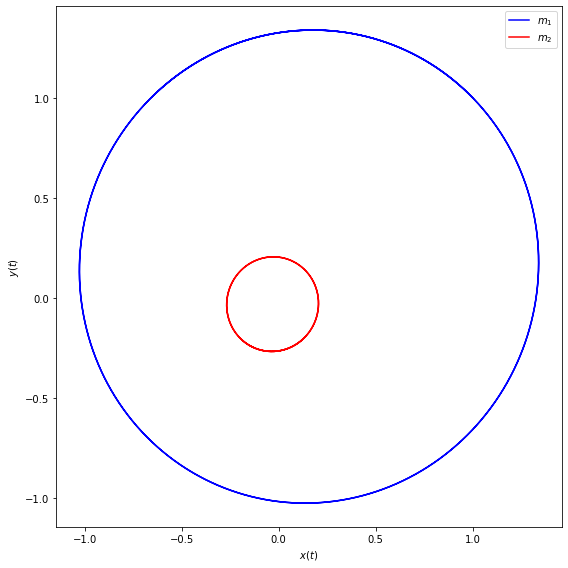

In [7]:
# both plots: same initial conditions
x1_0 = 1.
x1_dot_0 = -1.
y1_0 = 1.
y1_dot_0 = 1.

x2_0 = -(m1/m2)*x1_0
x2_dot_0 = -(m1/m2)*x1_dot_0
y2_0 = -(m1/m2)*y1_0
y2_dot_0 = -(m1/m2)*y1_dot_0

x1, x1_dot, x2, x2_dot, y1, y1_dot, y2, y2_dot = tb1.solve_ode(t_pts, x1_0, x1_dot_0, x2_0, x2_dot_0, 
                                                                      y1_0, y1_dot_0, y2_0, y2_dot_0)

# start the plot!
fig = plt.figure(figsize=(8,8))
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, 0., 10.)    
plot_y_vs_x(x1[start : stop], y1[start : stop], 
            axis_labels=(r'$x(t)$', r'$y(t)$'), 
            color='blue',
            label=r'$m_1$', 
            ax=ax_a)
plot_y_vs_x(x2[start : stop], y2[start : stop], 
            color='red',
            label=r'$m_2$', 
            ax=ax_a)

fig.tight_layout()
fig.savefig('two_body.png', bbox_inches='tight')

In [12]:
G = 20.
m1 = 20.
m2 = 1.

# Instantiate a pendulum 
tb1 = Two_Body(G=G, m1=m1, m2=m2)

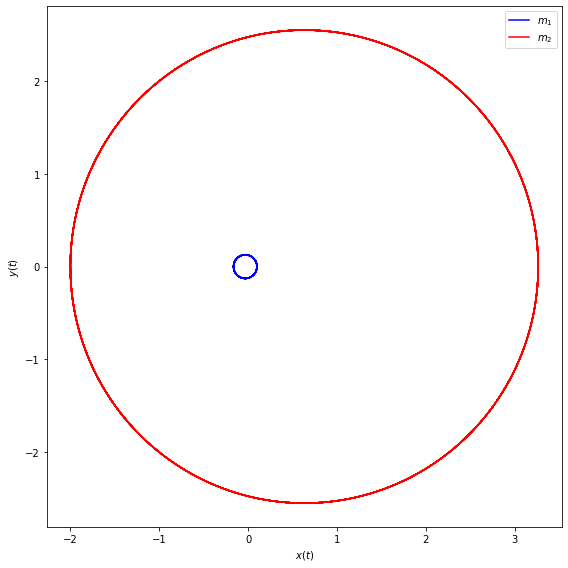

In [13]:
# both plots: same initial conditions
x1_0 = 0.1
x1_dot_0 = 0.
y1_0 = 0.
y1_dot_0 = 0.75

x2_0 = -(m1/m2)*x1_0
x2_dot_0 = -(m1/m2)*x1_dot_0
y2_0 = -(m1/m2)*y1_0
y2_dot_0 = -(m1/m2)*y1_dot_0

x1, x1_dot, x2, x2_dot, y1, y1_dot, y2, y2_dot = tb1.solve_ode(t_pts, x1_0, x1_dot_0, x2_0, x2_dot_0, 
                                                                      y1_0, y1_dot_0, y2_0, y2_dot_0)

# start the plot!
fig = plt.figure(figsize=(8,8))
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, 0., 10.)    
plot_y_vs_x(x1[start : stop], y1[start : stop], 
            axis_labels=(r'$x(t)$', r'$y(t)$'), 
            color='blue',
            label=r'$m_1$', 
            ax=ax_a)
plot_y_vs_x(x2[start : stop], y2[start : stop], 
            color='red',
            label=r'$m_2$', 
            ax=ax_a)

fig.tight_layout()
fig.savefig('two_body_heavy.png', bbox_inches='tight')

As shown in the plot above, if one of the bodies is very heavy, the orbit becomes similar to what we learned in class.

In [10]:
# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 50.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

G = 1.
m1 = 1.
m2 = 5.

# Instantiate a pendulum 
tb1 = Two_Body(G=G, m1=m1, m2=m2)

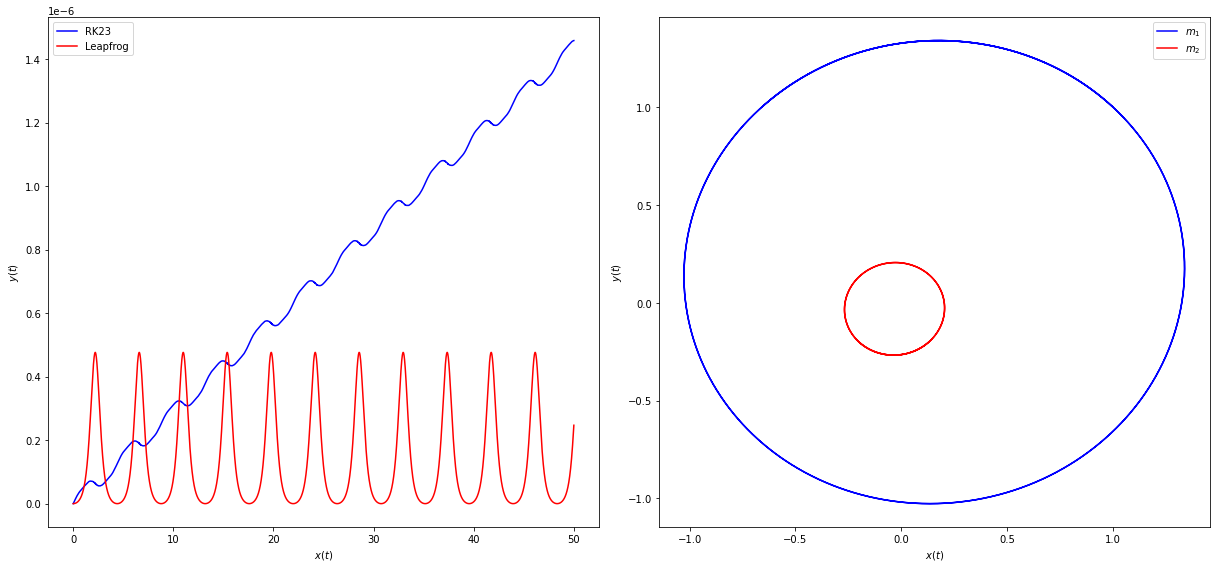

In [11]:
# both plots: same initial conditions
x1_0 = 1.
x1_dot_0 = -1.
y1_0 = 1.
y1_dot_0 = 1.

x2_0 = -(m1/m2)*x1_0
x2_dot_0 = -(m1/m2)*x1_dot_0
y2_0 = -(m1/m2)*y1_0
y2_dot_0 = -(m1/m2)*y1_dot_0

x1, x1_dot, x2, x2_dot, y1, y1_dot, y2, y2_dot = tb1.solve_ode(t_pts, x1_0, x1_dot_0, x2_0, x2_dot_0, 
                                                                      y1_0, y1_dot_0, y2_0, y2_dot_0)

x1_LF, x1_dot_LF, x2_LF, x2_dot_LF, y1_LF, y1_dot_LF, y2_LF, y2_dot_LF = tb1.solve_ode_Leapfrog(t_pts, 
                                                                        x1_0, x1_dot_0, x2_0, x2_dot_0, 
                                                                        y1_0, y1_dot_0, y2_0, y2_dot_0)

E_total = tb1.energy(x1, x1_dot, x2, x2_dot, y1, y1_dot, y2, y2_dot)
E_total_0 = E_total[0]
E_delta = np.fabs((E_total-E_total_0)/E_total_0)

E_total_LF = tb1.energy(x1_LF, x1_dot_LF, x2_LF, x2_dot_LF, y1_LF, y1_dot_LF, y2_LF, y2_dot_LF)
E_total_LF_0 = E_total_LF[0]
E_delta_LF = np.fabs((E_total_LF-E_total_LF_0)/E_total_LF_0)

# start the plot!
fig = plt.figure(figsize=(17,8))
ax_a = fig.add_subplot(1,2,1)                  

start, stop = start_stop_indices(t_pts, 0., 50.)    
plot_y_vs_x(t_pts[start : stop], E_delta[start : stop], 
            axis_labels=(r'$x(t)$', r'$y(t)$'), 
            color='blue',
            label=r'RK23', 
            ax=ax_a)
plot_y_vs_x(t_pts[start : stop], E_delta_LF[start : stop], 
            color='red',
            label=r'Leapfrog', 
            ax=ax_a)

ax_b = fig.add_subplot(1,2,2)                  

start, stop = start_stop_indices(t_pts, 0., 10.)    
plot_y_vs_x(x1_LF[start : stop], y1_LF[start : stop], 
            axis_labels=(r'$x(t)$', r'$y(t)$'), 
            color='blue',
            label=r'$m_1$', 
            ax=ax_b)
plot_y_vs_x(x2_LF[start : stop], y2_LF[start : stop], 
            color='red',
            label=r'$m_2$', 
            ax=ax_b)

fig.tight_layout()

As shown in the plot on the left, the energy is conserved when solving the ODE using the Leapfrog method.